In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import keras.preprocessing.image as process_im
from tqdm import tqdm_notebook as tqdm
from sklearn.utils import class_weight, shuffle
from PIL import Image
from keras import applications
from keras import optimizers
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.python.keras import backend as K



#훈련 집합
foldernames = os.listdir("D:/Dataset/Images/data/afhq/train")
categories = []
files = []
i = 0
for k, folder in enumerate(foldernames):
    filenames = os.listdir("D:/Dataset/Images/data/afhq/train/" + folder)
    for file in filenames:
        files.append("D:/Dataset/Images/data/afhq/train/" + folder + "/" + file)
        categories.append(k)
        
df = pd.DataFrame({
    'filename': files,
    'category': categories
})
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

##############테스트 집합
foldernames2 = os.listdir("D:/Dataset/Images/test")
categories2 = []
files2 = []
i = 0
k = 0
filenames2 = os.listdir("D:/Dataset/Images/test")
for file2 in filenames2:
    files2.append("D:/Dataset/Images/test/" + file2)
    categories2.append(k)
        
test_df = pd.DataFrame({
    'filename': files2,
    'category': categories2
})
#######################
df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    test_df = test_df.append(df[df.category == i].iloc[:500,:])

test_df.head()
test_df = test_df.reset_index(drop=True)
test_df

y = train_df['category']
x = train_df['filename']
y = train_df['category']

x, y = shuffle(x, y, random_state=8)

def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

images = []

with tqdm(total=len(train_df)) as pbar:
    for i, file_path in enumerate(train_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images.append(img)
        pbar.update(1)
images = np.array(images)




images2 = []
with tqdm(total=len(test_df)) as pbar:
    for i, file_path in enumerate(test_df.filename.values):
        #read image
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        #resize
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering
        img = centering_image(cv2.resize(img, dsize=tile_size))

        #out put 224*224px 
        img = img[16:240, 16:240]
        images2.append(img)
        pbar.update(1)
images2 = np.array(images2)




Using TensorFlow backend.
D:\anaconda\envs\project\lib\site-packages\ipykernel_launcher.py:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


D:\anaconda\envs\project\lib\site-packages\ipykernel_launcher.py:115: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


x_train (2403, 224, 224, 3)
y_train (2403,)
x_test (601, 224, 224, 3)
y_test (601,)


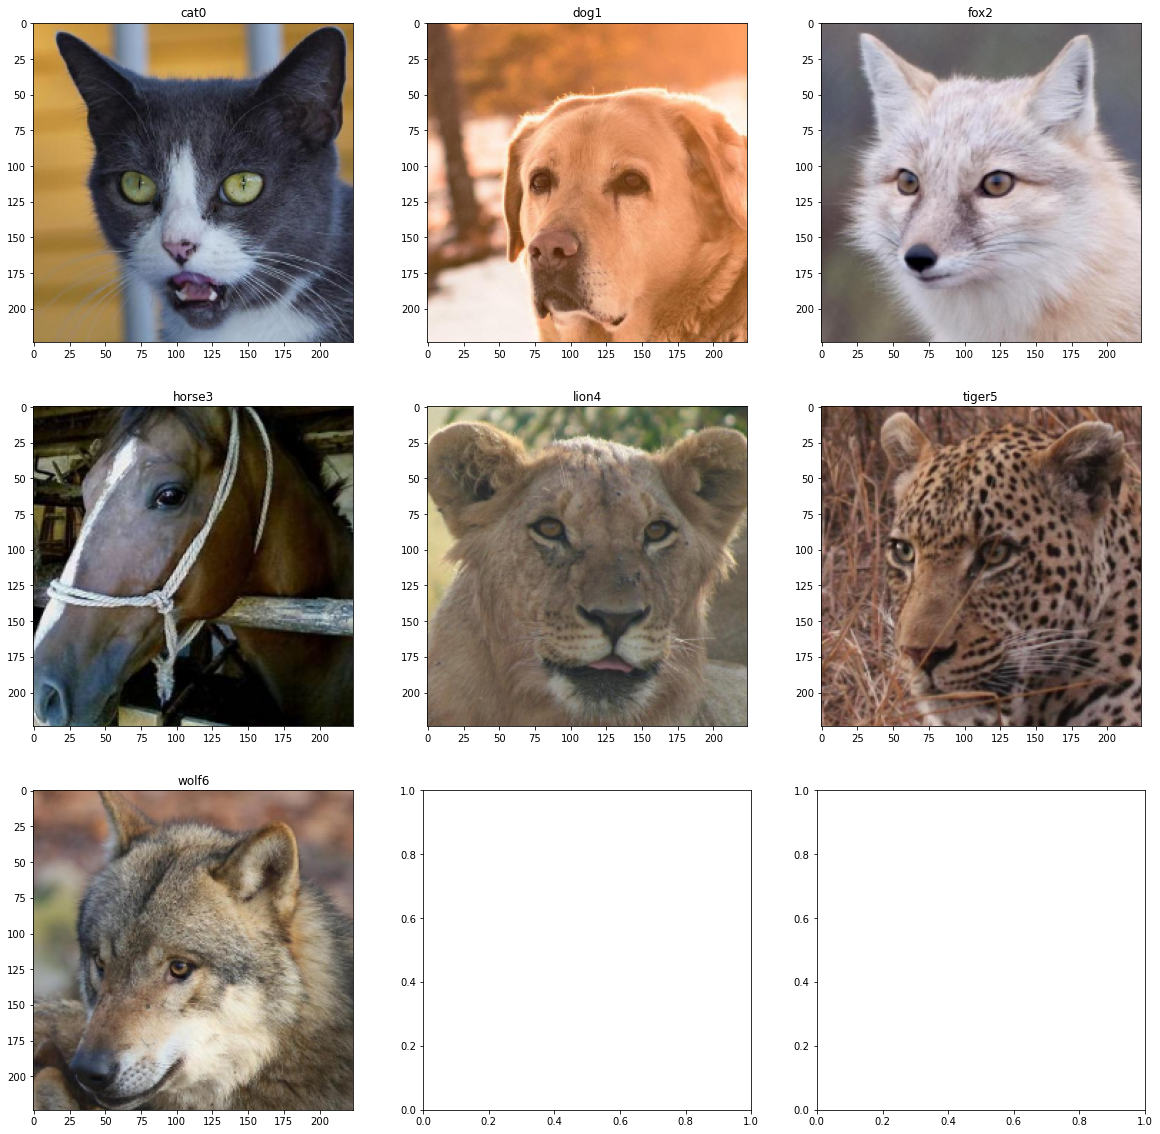

In [2]:
rows,cols = 3,3
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for i in range(7):
    path = train_df[train_df.category == i].values[2]
#     image = cv2.imread(path[0])/
    axes[i//cols, i%cols].set_title(path[0].split('/')[-2] + str(path[1]))
    axes[i//cols, i%cols].imshow(images[train_df[train_df.filename == path[0]].index[0]])

    data_num = len(y)
random_index = np.random.permutation(data_num)

x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)
val_split_num = int(round(0.2*len(y)))
x_train = x[val_split_num:]
y_train = y[val_split_num:]
x_test = x[:val_split_num]
y_test = y[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

img_rows, img_cols, img_channel = 224, 224, 3
name_animal = []
for i in range(7):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'cat':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'dog':
        name_animal.append('dog')
    elif path[0].split('/')[-2] == 'fox':
        name_animal.append('fox')
    elif path[0].split('/')[-2] == 'horse':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'lion':
        name_animal.append('lion')
    elif path[0].split('/')[-2] == 'tiger':
        name_animal.append('tiger')
    elif path[0].split('/')[-2] == 'wolf':
        name_animal.append('wolf')
    

In [ ]:

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(7, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

batch_size = 64
epochs = 50

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)


history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc')]
)

In [ ]:
#그래프

print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['acc'][epochs-1],history.history['val_acc'][epochs-1]))
def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals
show_plots(history.history)




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
path :  ['D:/Dataset/Images/test/a.jpg' 0]
path :  ['D:/Dataset/Images/test/b.jpg' 0]
path :  ['D:/Dataset/Images/test/c.jpg' 0]
path :  ['D:/Dataset/Images/test/d.jpg' 0]
path :  ['D:/Dataset/Images/test/e.jpg' 0]
path :  ['D:/Dataset/Images/test/f.jpg' 0]
path :  ['D:/Dataset/Images/test/g.jpg' 0]
path :  ['D:/Dataset/Images/test/h.jpg' 0]
path :  ['D:/Dataset/Images/test/i.jpg' 0]
path :  ['D:/Dataset/Images/test/j.jpg' 0]
path :  ['D:/Dataset/Images/test/k.jpg' 0]
path :  ['D:/Dataset/Images/test/l.jpg' 0]
path :  ['D:/Dataset/Images/test/m.jpg' 0]
path :  ['D:/Dataset/Images/test/n.jpg' 0]
path :  ['D:/Dataset/Images/test/o.jpg' 0]


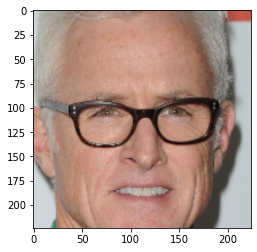

Predict : dog
Values :  1


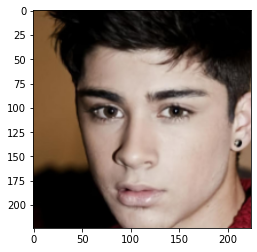

Predict : cat
Values :  0


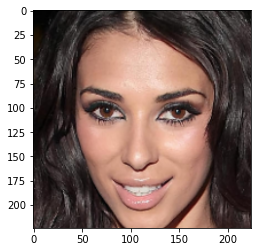

Predict : dog
Values :  1


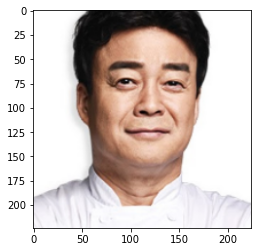

Predict : cat
Values :  0


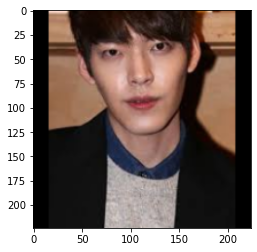

Predict : horse
Values :  3


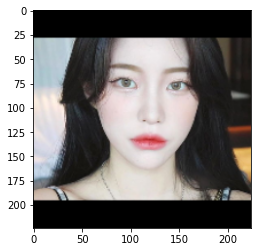

Predict : cat
Values :  0


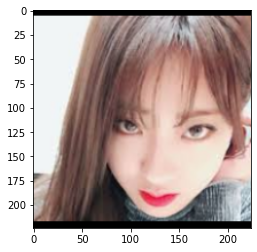

Predict : cat
Values :  0


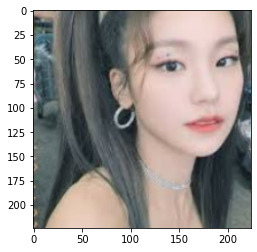

Predict : cat
Values :  0


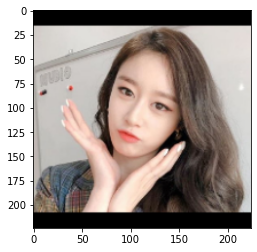

Predict : dog
Values :  1


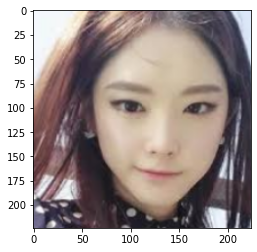

Predict : tiger
Values :  5


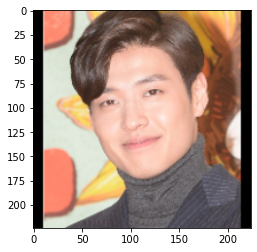

Predict : dog
Values :  1


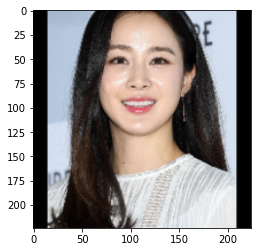

Predict : horse
Values :  3


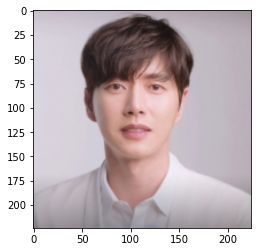

Predict : tiger
Values :  5


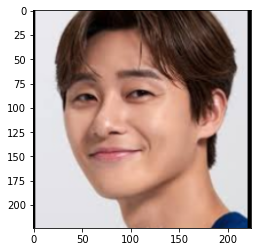

Predict : dog
Values :  1


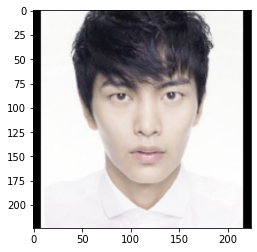

Predict : cat
Values :  0


In [3]:
from keras.models import load_model
model = load_model('classification_afhqv2.model')
tf.compat.v1.disable_eager_execution()
test_images2 = []
for i in range(15):
    path = test_df.values[i]
    print("path : ", path)
    a2 = images2[test_df.index[i]]
    img = np.array(a2)
    img = img[:, :, ::-1].copy() 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = centering_image(cv2.resize(img, dsize=tile_size))
    img = img[16:240, 16:240]
    test_images2.append(img)
test_images2 = np.array(test_images2).reshape(-1,224,224,3)
something = model.predict(test_images2)
animals = name_animal
i = 0
pre_arr = np.array([])
for pred in something:
    plt.imshow(test_images2[i])
    plt.show()
    print('Predict :', animals[np.where(pred.max() == pred)[0][0]])
    print('Values : ',np.where(pred.max() == pred)[0][0])
    pre_arr= np.append(pre_arr,np.where(pred.max() == pred)[0][0])
    i += 1

In [ ]:
np.save(pre_arr)